<a href="https://colab.research.google.com/github/snehaa-13/shock-propagation/blob/main/static_shock_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

injecting shock to the simulated dataset, any one bank goes default

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving cleaned_bank_data.csv to cleaned_bank_data.csv
Saving cleaned_loan_data.csv to cleaned_loan_data.csv


In [ ]:
import pandas as pd

bank_df = pd.read_csv('cleaned_bank_data.csv')
loan_df = pd.read_csv('cleaned_loan_data.csv')


In [ ]:
import numpy as np

shock_percent = 0.05
num_banks = len(bank_df['bank_id'].unique())
num_to_shock = int(num_banks * shock_percent)

shock_ids = np.random.choice(bank_df['bank_id'].unique(), size=num_to_shock, replace=False)


bank_df['shock_flag'] = 0
bank_df.loc[bank_df['bank_id'].isin(shock_ids), 'shock_flag'] = 1
bank_df.loc[bank_df['bank_id'].isin(shock_ids), 'equity'] = 0

print(f"Injected shock to banks: {shock_ids}")


Injected shock to banks: ['B54' 'B39' 'B10']


In [ ]:

bank_df.to_csv('shocked_bank_data.csv', index=False)
loan_df.to_csv('loan_data.csv', index=False)

from google.colab import files
files.download('shocked_bank_data.csv')
files.download('loan_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

debtrank algo

In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(loan_df, source='source', target='target', edge_attr='exposure', create_using=nx.DiGraph())


for idx, row in bank_df.iterrows():
    G.nodes[row['bank_id']]['equity'] = row['equity']
    G.nodes[row['bank_id']]['shock_flag'] = row['shock_flag']


In [ ]:
# Initialize distress (h) vector
h = {node: 1.0 if G.nodes[node]['shock_flag'] == 1 else 0.0 for node in G.nodes()}
active = {node: True if G.nodes[node]['shock_flag'] == 1 else False for node in G.nodes()}

max_iter = 10  # Number of propagation rounds
alpha = 1.0    # Propagation strength

for t in range(max_iter):
    new_h = h.copy()
    for i in G.nodes():
        if not active[i]:  # Only update undistressed banks
            total_impact = 0
            for j in G.predecessors(i):  # Who lends to i
                if active[j]:
                    exposure = G[j][i]['exposure']
                    equity = G.nodes[i]['equity']
                    if equity > 0:
                        total_impact += alpha * (exposure / equity) * h[j]
            if total_impact > 0:
                new_h[i] = min(1.0, new_h[i] + total_impact)
                active[i] = True
    if new_h == h:
        break
    h = new_h

# Store DebtRank values in dataframe
debt_rank_df = pd.DataFrame(list(h.items()), columns=['bank_id', 'debt_rank'])
debt_rank_df.sort_values(by='debt_rank', ascending=False, inplace=True)


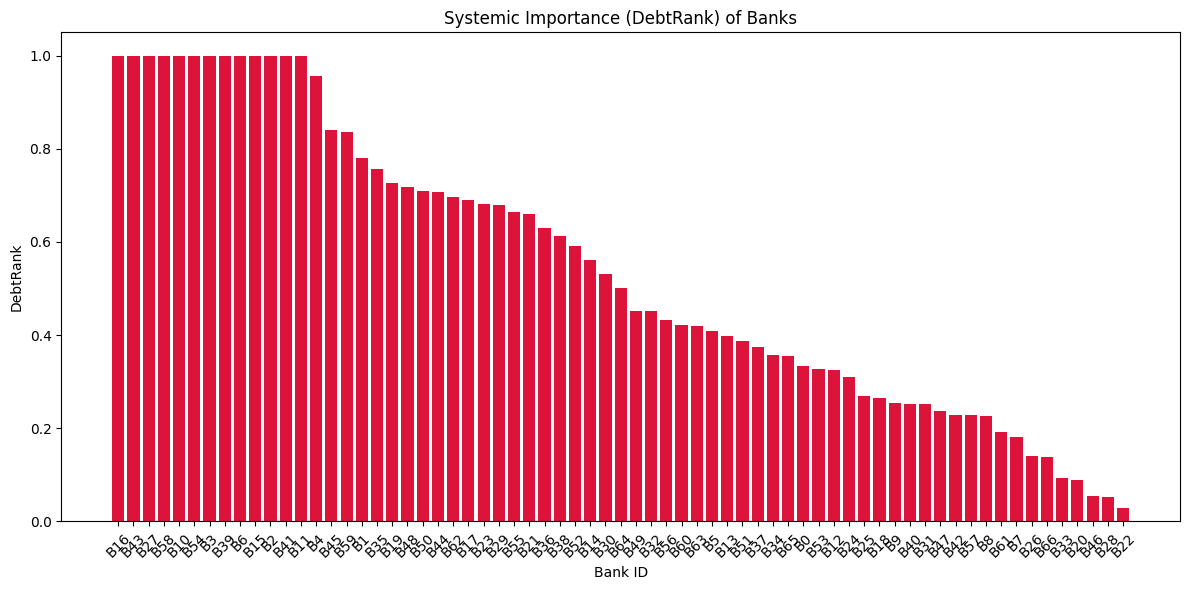

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(debt_rank_df['bank_id'].astype(str), debt_rank_df['debt_rank'], color='crimson')
plt.xlabel("Bank ID")
plt.ylabel("DebtRank")
plt.title("Systemic Importance (DebtRank) of Banks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
debt_rank_df.to_csv('debt_rank_scores.csv', index=False)
files.download('debt_rank_scores.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>